## Introduction
Generally speaking, future market prices are unpredictable and almost random. But there is always a correlation between different assets, which is not random and probably can be used to get more accurate price evaluation, especially during crises and high volatility. In this kernel I will show that deep neural network after analysed the most influential historical data and grasped fundamental dependencies is capable enough to accurately detect anomalies in USD/RUB pricing. And based on Regression toward the mean phenomenon we can bet against those anomalies. Based on my knowledge and understanding of the markets the most significant assets to influence USD/RUB price are: government bonds, repo rates, oil, and stock indexes. Let's examine those dependencies first. 

In [ ]:
!pip install catboost sklearn shap

In [114]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import norm
import matplotlib.pyplot as plt
from matplotlib import dates as mpl_dates
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.linear_model import Ridge
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from catboost import Pool
from catboost import CatBoostRegressor

plt.style.use('seaborn')
import warnings
warnings.filterwarnings('ignore')

## Read in dataset with market data from csv 

In [115]:
main_df = pd.read_csv('market_data.csv')
main_df.Date = pd.to_datetime(main_df.Date,yearfirst=True)
main_df

,Date,Brent,EUR_USD,Emerging_Markets,MOEXBC,RGBITR_YIELD,Russia_ETF,Treas_4M,USD_Repo,USD_RUB
0,2017-03-13,51.43,1.06545,36.708759,13023.33,8.34,18.135187,0.728,1.16,58.7725
1,2017-03-14,51.56,1.06000,36.499207,13016.08,8.33,17.879892,0.753,1.17,59.1600
2,2017-03-15,51.97,1.07255,37.451694,12957.17,8.28,18.426956,0.715,1.16,58.3900
3,2017-03-16,51.74,1.07675,37.680290,13093.18,8.22,18.627546,0.708,1.29,57.7900
4,2017-03-17,51.75,1.07360,37.613617,13247.03,8.21,19.046963,0.708,1.31,57.2200
...,...,...,...,...,...,...,...,...,...,...
596,2019-08-22,59.89,1.10800,39.639999,18186.19,7.15,22.080000,1.938,2.09,65.6000
597,2019-08-23,58.78,1.11348,39.049999,18058.85,7.15,21.740000,1.910,2.11,65.9850
598,2019-08-26,59.16,1.10978,39.259998,18015.13,7.16,21.860001,1.933,2.10,66.0700
599,2019-08-27,58.70,1.10898,39.330002,17973.86,7.17,21.719999,1.943,2.09,66.4425


## Some basic exploratory Data Analysis (EDA)

In [116]:
main_df.describe()

,Brent,EUR_USD,Emerging_Markets,MOEXBC,RGBITR_YIELD,Russia_ETF,Treas_4M,USD_Repo,USD_RUB
count,601.000000,601.000000,601.000000,601.000000,601.000000,601.000000,601.000000,601.000000,601.000000
mean,64.323245,1.154990,42.371286,15155.645141,7.813045,20.260870,1.709245,2.213710,61.871676
std,9.372336,0.041284,2.822193,1861.955099,0.505143,1.500698,0.552593,0.593644,3.875063
min,44.770000,1.059250,36.499207,11762.240000,6.820000,16.566936,0.708000,1.000000,55.705000
25%,56.980000,1.125650,39.985130,13445.230000,7.400000,19.246469,1.083000,1.790000,57.900000
50%,64.270000,1.149840,42.365707,15191.330000,7.830000,20.159327,1.870000,2.310000,62.505000
75%,71.880000,1.179200,44.084286,16511.380000,8.200000,21.209999,2.258000,2.500000,65.490000
max,85.900000,1.251700,50.590469,19251.210000,9.100000,24.120001,2.408000,4.090000,70.565000


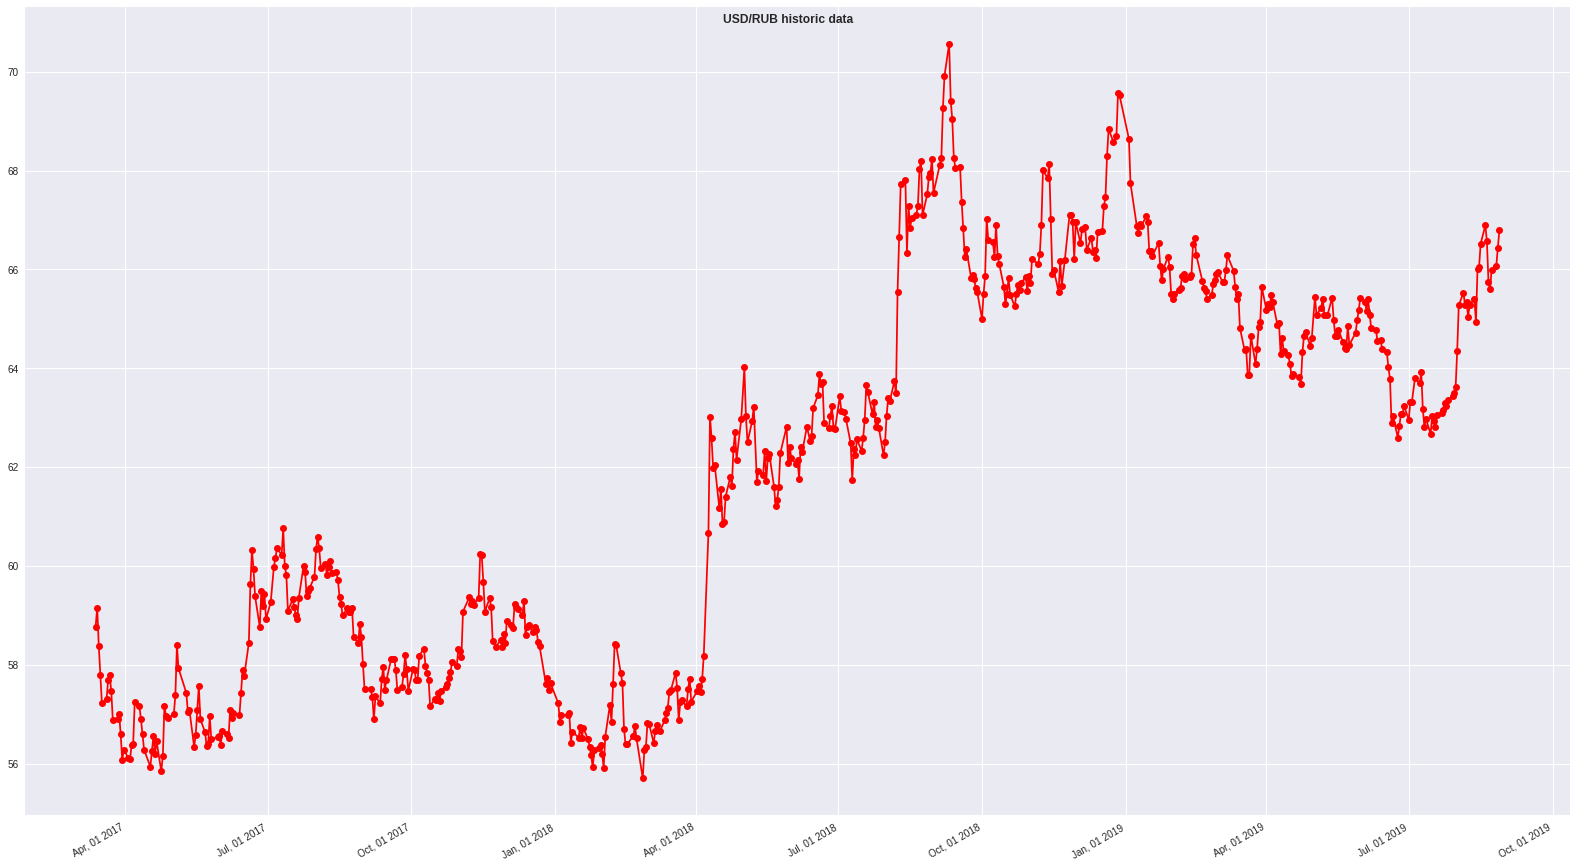

In [117]:
fig, axs = plt.subplots(figsize=(22,12))
fig.suptitle('USD/RUB historic data', fontweight ="bold")

plt.plot_date(main_df.Date, main_df.USD_RUB, color='red',  linestyle = 'solid')
plt.gcf().autofmt_xdate()

date_format = mpl_dates.DateFormatter('%b, %d %Y')
plt.tight_layout()
plt.gca().xaxis.set_major_formatter(date_format)

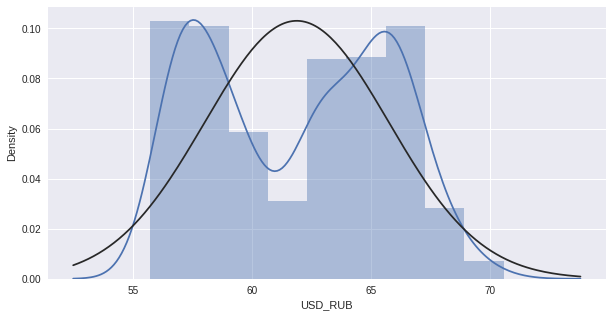

In [8]:
fig = plt.figure(figsize=(10,5))
sns.distplot(main_df['USD_RUB'], fit=norm)

Our target USD_RUB is not normally distributed thus making prediction modeling harder. Let's explore correlations between our target and features. 

In [49]:
main_df.drop('Date', 1, inplace=True)
corr_df= pd.DataFrame(abs(main_df.corr().USD_RUB).sort_values(ascending=False))
corr_df.rename(columns={'USD_RUB': 'corr_original'}, inplace=True)
corr_df

,corr_original
USD_RUB,1.000000
Treas_4M,0.864866
MOEXBC,0.695755
USD_Repo,0.621623
RGBITR_YIELD,0.567899
Brent,0.474665
Emerging_Markets,0.331401
EUR_USD,0.296095
Russia_ETF,0.127072


As we can see correlation with bonds indexes, stock indexes, repo rates and oil prices are the strongest. Let's explore mutual information of features and target.

In [50]:
X = main_df.drop('USD_RUB', 1)
y =  main_df.USD_RUB

def make_mi_scores(X, y):
    mi_scores = mutual_info_regression(X, y)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

mi_scores = make_mi_scores(X, y)
mi_scores 

Treas_4M            1.185643
MOEXBC              1.183746
RGBITR_YIELD        1.044095
Russia_ETF          0.930938
Brent               0.914964
USD_Repo            0.896275
EUR_USD             0.857428
Emerging_Markets    0.787700
Name: MI Scores, dtype: float64

Surprisingly enough, all features exhibit a strong relationship with the target. Since nonlinear relationships are possible, mutual information scores are more important

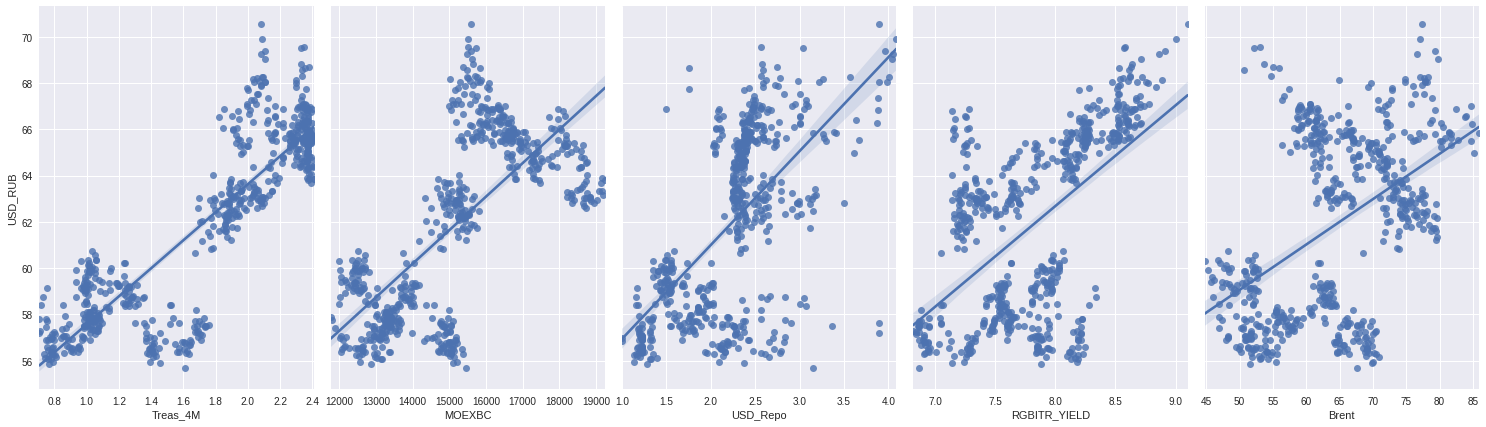

In [118]:
sns.pairplot(main_df, x_vars=['Treas_4M','MOEXBC','USD_Repo','RGBITR_YIELD','Brent'], y_vars='USD_RUB', height=6, aspect=0.7, kind='reg')

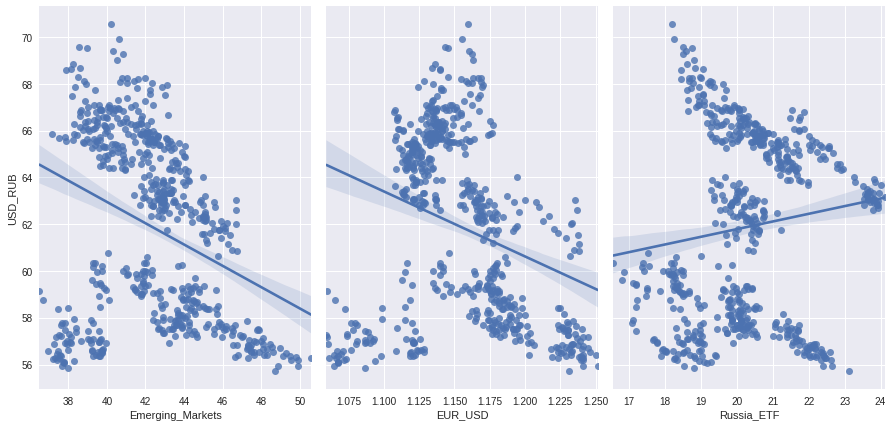

In [119]:
sns.pairplot(main_df, x_vars=['Emerging_Markets','EUR_USD','Russia_ETF'], y_vars='USD_RUB', height=6, aspect=0.7, kind='reg')

## Train/test split

In [51]:
X_train = X[(X.index < int(0.8*len(X)))]
y_train = y[(y.index < int(0.8*len(y)))]

X_test = X[(X.index >= int(0.8*len(X)))]
y_test = y[(y.index >= int(0.8*len(y)))]

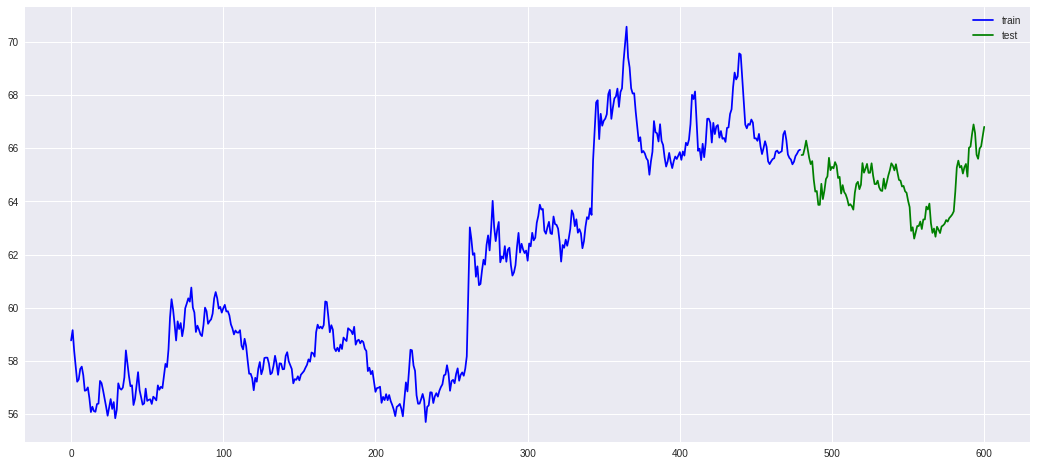

In [52]:
fig, ax = plt.subplots(figsize=(18,8))
plt.plot(y_train, color='blue', label='train')
plt.plot(y_test, color='green', label='test')
plt.legend()

##Feature-wise normalisation


In [53]:
pipeline = Pipeline([('std_scalar', StandardScaler())])

X_train = pipeline.fit_transform(X_train)
X_test = pipeline.transform(X_test)

##Let's try a few basic ML models

In [54]:
def print_evaluate(true, predicted):  
    mae = metrics.mean_absolute_error(true, predicted).round(3)    
    rmse = np.sqrt(metrics.mean_squared_error(true, predicted)).round(3)      
    print('MAE:', mae)
    print('RMSE:', rmse)
        
def evaluate(true, predicted):
    mae = metrics.mean_absolute_error(true, predicted).round(3)      
    rmse = np.sqrt(metrics.mean_squared_error(true, predicted)).round(3)      
    return mae,  rmse

In [55]:
model = Ridge(alpha = 100)
model.fit(X_train, y_train)
pred = model.predict(X_test)

test_pred = model.predict(X_test)
train_pred = model.predict(X_train)

print('Test set evaluation:')
print_evaluate(y_test, test_pred)
print()
print('Train set evaluation:')
print_evaluate(y_train, train_pred)

Test set evaluation:
MAE: 1.573
RMSE: 2.185

Train set evaluation:
MAE: 0.814
RMSE: 0.988


In [56]:
results_df = pd.DataFrame(data=[["Ridge Regression", *evaluate(y_test, test_pred)]], columns=['Model', 'MAE',  'RMSE'])
results_df

,Model,MAE,RMSE
0,Ridge Regression,1.573,2.185


In [57]:
early_stopping = EarlyStopping(
    min_delta=0.01, # minimium amount of change to count as an improvement
    patience=10, # how many epochs to wait before stopping
    restore_best_weights=True,)

model = keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=[X_train.shape[1]]),
    layers.Dropout(0.2),
    layers.BatchNormalization(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.2),
    layers.BatchNormalization(),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.2),
    layers.BatchNormalization(),
    layers.Dense(1),])

model.compile(optimizer=Adam(0.001), loss='mae')

history  = model.fit(X_train, y_train,validation_data=(X_test,y_test), batch_size=10, epochs = 100, callbacks=[early_stopping],verbose=0)

 Minimum validation loss(mae): 1.057


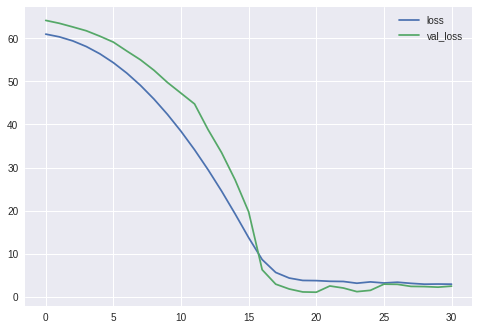

In [58]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot();
print(f' Minimum validation loss(mae): {round(history_df.val_loss.min(),3)}')

In [59]:
test_pred = model.predict(X_test)
train_pred = model.predict(X_train)

print('Test set evaluation:')
print_evaluate(y_test, test_pred)
print()
print('Train set evaluation:')
print_evaluate(y_train, train_pred)

Test set evaluation:
MAE: 1.057
RMSE: 1.599

Train set evaluation:
MAE: 1.607
RMSE: 2.044


In [60]:
results_df_1 = pd.DataFrame(data=[["DNN", *evaluate(y_test, test_pred)]], columns=['Model', 'MAE',  'RMSE'])
results_df = results_df.append(results_df_1, ignore_index=True)
results_df

,Model,MAE,RMSE
0,Ridge Regression,1.573,2.185
1,DNN,1.057,1.599


In [61]:
train_pool = Pool(data=X_train, label=y_train)
validation_pool = Pool(data=X_test, label=y_test)

model = CatBoostRegressor(iterations=1000, learning_rate=0.005, custom_metric=['MAE'])

model.fit(train_pool, eval_set=validation_pool, verbose= 100)

print('Model is fitted: {}'.format(model.is_fitted()))
print('Model params:\n{}'.format(model.get_params()))

0:	learn: 4.0088642	test: 3.5243129	best: 3.5243129 (0)	total: 49.4ms	remaining: 49.3s
100:	learn: 2.6636049	test: 2.4780827	best: 2.4780827 (100)	total: 283ms	remaining: 2.52s
200:	learn: 1.8278306	test: 1.9376658	best: 1.9376658 (200)	total: 501ms	remaining: 1.99s
300:	learn: 1.3014829	test: 1.6761705	best: 1.6761705 (300)	total: 730ms	remaining: 1.7s
400:	learn: 0.9798563	test: 1.5655638	best: 1.5655638 (400)	total: 959ms	remaining: 1.43s
500:	learn: 0.7801607	test: 1.5237133	best: 1.5222972 (496)	total: 1.18s	remaining: 1.18s
600:	learn: 0.6539033	test: 1.5108892	best: 1.5105895 (595)	total: 1.41s	remaining: 939ms
700:	learn: 0.5713792	test: 1.5082666	best: 1.5061544 (631)	total: 1.64s	remaining: 698ms
800:	learn: 0.5144664	test: 1.5124738	best: 1.5061544 (631)	total: 1.85s	remaining: 460ms
900:	learn: 0.4730846	test: 1.5138510	best: 1.5061544 (631)	total: 2.07s	remaining: 228ms
999:	learn: 0.4414375	test: 1.5172147	best: 1.5061544 (631)	total: 2.3s	remaining: 0us

bestTest = 1.506

In [62]:
MAE = round(model.best_score_['validation']['MAE'],3)
RMSE =  round(model.best_score_['validation']['RMSE'],3)

results_df_2 = pd.DataFrame(data=[['CatBoost', MAE, RMSE]], columns=['Model', 'MAE',  'RMSE'])
results_df = results_df.append(results_df_2, ignore_index=True)
results_df

,Model,MAE,RMSE
0,Ridge Regression,1.573,2.185
1,DNN,1.057,1.599
2,CatBoost,0.892,1.506


Since price movements are volatile and the main idea is to be good in evaluating fundamental price MAE metric (Mean Absolute Error) is preferable. CatBoost looks promising and it has a lot of potential for optimization and hyperparameters tuning.  

In [ ]:
X_grid_search = main_df.drop('USD_RUB', 1) 
y_grid_search =  main_df.USD_RUB

pool = Pool(data=X_grid_search, label=y_grid_search)
model = CatBoostRegressor(iterations=1000, learning_rate=0.005, custom_metric=['MAE'])

grid = {'learning_rate': [0.1, 0.05, 0.025, 0.01], 'iterations':[1000, 1500, 2000], 'depth': [1 , 2, 3, 4]}
result = model.grid_search(grid, pool)

In [70]:
model = CatBoostRegressor(iterations=2000, learning_rate=0.05, depth =2, custom_metric=['MAE'])
model.fit(train_pool, eval_set=validation_pool, verbose= False)

print(f'Model is fitted: {model.is_fitted()}')
print(f'Model params:\n{model.get_params()}')

Model is fitted: True
Model params:
{'iterations': 2000, 'learning_rate': 0.05, 'depth': 2, 'loss_function': 'RMSE', 'custom_metric': ['MAE']}


In [71]:
MAE = round(model.best_score_['validation']['MAE'],3)
print(f'Best score\nMAE = {MAE}')

Best score
MAE = 0.873


In [72]:
model.get_feature_importance(prettified=True)

,Feature Id,Importances
0,6,76.284862
1,3,10.933152
2,0,4.599529
3,4,4.458255
4,5,1.866174
5,2,1.151370
6,1,0.527683
7,7,0.178975


Treas_4M and MOEXBC (US government bonds and Russian stock index) are two most important features

## Some basic quantitative analysis of the results.

In [95]:
prediction = model.predict(pipeline.transform(X))

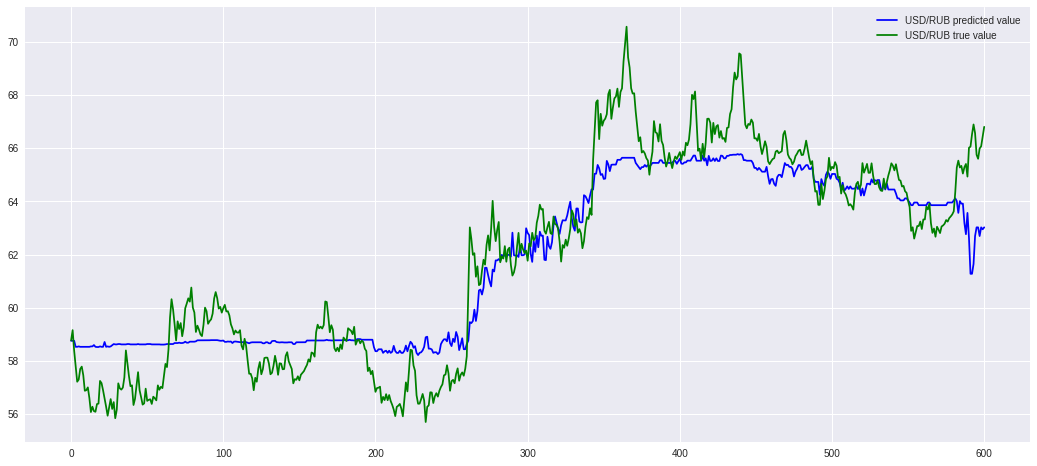

In [97]:
fig, ax = plt.subplots(figsize=(18,8))
plt.plot(prediction, color='blue', label='USD/RUB predicted value')
plt.plot(y, color='green', label='USD/RUB true value')
plt.legend()

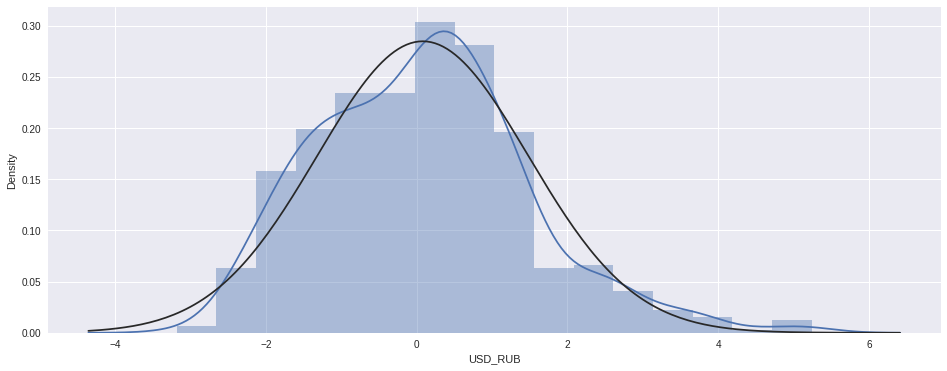

In [101]:
deviation = y - prediction
fig = plt.figure(figsize=(16,6))
sns.distplot(deviation, bins=16, fit=norm);

Unlike USD/RUB, prediction error has quite normal (Gaussian) distribution thus Empirical Rule can be applied.  

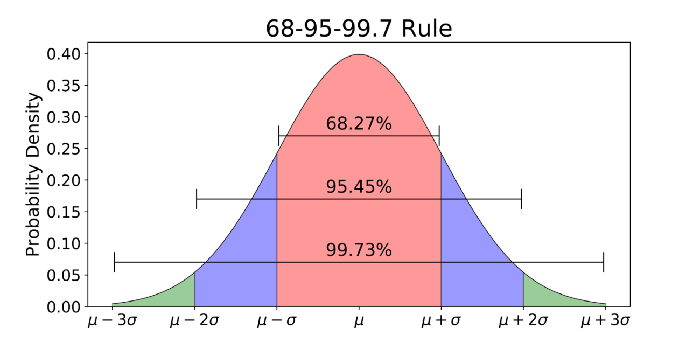

The normal distribution is commonly associated with the 68-95-99.7 rule which you can see in the image above. 68% of the data is within 1 standard deviation (σ) of the mean (μ), 95% of the data is within 2 standard deviations (σ) of the mean (μ), and 99.7% of the data is within 3 standard deviations (σ) of the mean (μ).

In [120]:
USD_mean = round(y.mean(),2)
USD_std =round(y.std(),2)

mean_error = round(deviation.mean(),2)

std_deviation =  round(deviation.std(),2)
relative_mispricing = deviation/std_deviation

Upper_limit = mean_error + 2*std_deviation
Lower_limit = mean_error - 2*std_deviation

print("USD mean value =", USD_mean) # calculated for the all cleaned dataset 
print("USD standard deviation =", USD_std) # calculated for the all cleaned dataset
print("Mean Error =",mean_error) # Mean Error of our prediction calculated for the all cleaned dataset
print("Standard deviation of the error =", std_deviation) # standard deviation of  prediction error calculated for the all cleaned dataset

USD mean value = 61.87
USD standard deviation = 3.88
Mean Error = 0.08
Standard deviation of the error = 1.4


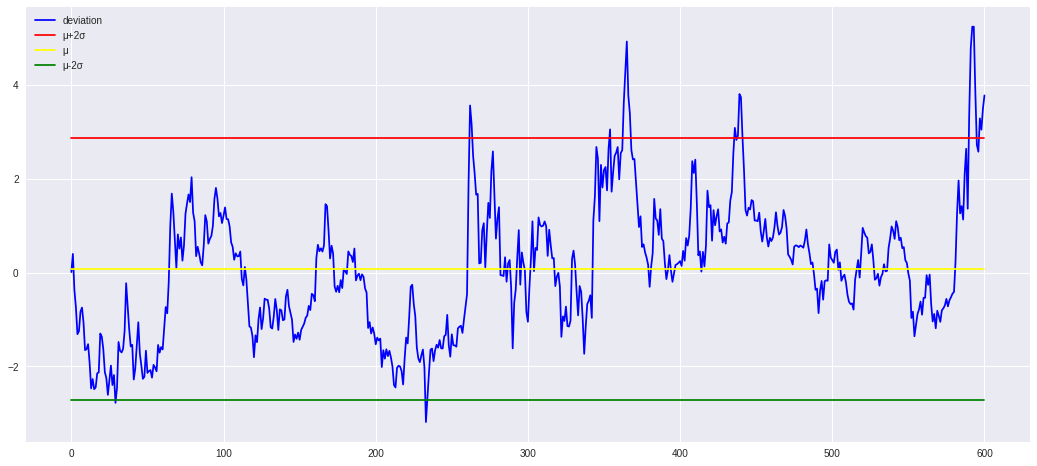

In [113]:
fig, ax = plt.subplots(figsize=(18,8))
plt.plot(deviation, color='blue', label='deviation')
plt.plot(np.full((601, ),Upper_limit), color='red', label='μ+2σ')
plt.plot(np.full((601, ),mean_error), color='yellow', label='μ')
plt.plot(np.full((601, ),Lower_limit), color='green', label='μ-2σ')
plt.legend()

## Wrapping up
Quantitative analysis and statistical approach of assets pricing can be useful and give good results for the purposes of 'fair' baised on underlying fundamentals pricing as well as detection and evaluation of anomalys in market pricing. And even though fundamentals isn't always price movement's main driving force good understanding of them can give some adge.